In [2]:
import pandas as pd
import numpy as np
import random 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

import matplotlib
%matplotlib inline

In [22]:
def prep(df):

    # A few columns have to go for us to build a model (though we use them for user presentation)
    df.drop(['YardLineFixed', 'YardLineDirection','Description', 'PlayType', \
             'PassType', 'RushDirection', 'Yards', 'DefenseTeam'], axis=1, inplace=True)

    # create dummy variables for formations
    form_dummies = pd.get_dummies(df.Formation)
    form_dummies.columns = map(lambda x: 'FORMATION_' + x.replace (' ', '_'), form_dummies.columns)

    # create dummy variables for teams
    team_dummies = pd.get_dummies(df.OffenseTeam)
    team_dummies.columns = map(lambda x: 'TEAM_' + str(x), team_dummies.columns)

    # combine the dummy variables and drop the categorical versions
    df_prepped = pd.concat(
        [df.ix[:,['Quarter', 'Minute', 'Second', 'Down', 'ToGo', 'YardLine', 'Play']],
        team_dummies,
        form_dummies], axis=1)

    return df_prepped

In [6]:
def combine(filenames):

    dfs = []
    for filename in filenames:
        dfs.append(pd.read_csv(filename))

    df = pd.concat(dfs)

    return df

In [9]:
def plot_confusion_matrix(cm):
    '''Code stolen brazenly from sklearn example.'''
    print(cm)

    # Show confusion matrix in a separate window
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Split off a validation set for the users and models to compete over

In [18]:
# read in the cleaned data, combine it, but leave it without dummies
filenames = ['data/pbp2016-clean.csv', 'data/pbp2015-clean.csv', 'data/pbp2014-clean.csv', 'data/pbp2013-clean.csv']
pbp_raw = combine(filenames)

In [19]:
pbp_train, pbp_validation = train_test_split(pbp_raw, test_size = 0.1) # 10% is about 13.5k plays

In [21]:
pbp_train.to_csv('data/pbp-training.csv')

In [20]:
pbp_validation.to_csv('data/pbp-validation.csv', index=False)

In [28]:
print 'training set:  ', pbp_train.shape
print 'validation set:', pbp_validation.shape

training set:   (121498, 17)
validation set: (13500, 17)


## Prep the training set

In [24]:
pbp_train_raw = pd.read_csv('data/pbp-training.csv')

In [25]:
pbp = prep(pbp_train_raw)

In [29]:
# split the class from the values
y = pbp['Play']
X = pbp.drop(['Play'], axis=1).values

# save a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

### Basic Model Using All Seasons and All Teams

In [30]:
# gradient boosting classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

In [31]:
gbc.score(X_test, y_test)

0.77125925925925931

[[ 2871     1    12]
 [   10 13351  3540]
 [    3  3382  7205]]


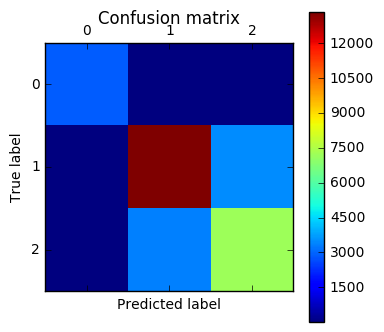

In [32]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))